# NarrativeQA

## Load data

In [1]:
import csv

from tqdm import tqdm

summaries = {
    "train": {},
    "valid": {},
    "test": {}
}
with open('../original_data/NarrativeQA/summaries.csv', 'r') as f:
    csvreader = csv.DictReader(f)
    for row in tqdm(csvreader, desc="analysing summaries"):
        summaries[row["set"]][row["document_id"]] = row["summary"]

analysing summaries: 1572it [00:00, 20004.57it/s]


In [2]:
questions = {
    "train": {"count": 0, "samples": {}},
    "valid": {"count": 0, "samples": {}},
    "test": {"count": 0, "samples": {}}
}

with open('../original_data/NarrativeQA/qaps.csv', 'r') as f:
    n_questions = len(f.readlines())

with open('../original_data/NarrativeQA/qaps.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in tqdm(reader, desc="analysing questions", total=n_questions):
        set = row["set"]
        doc_id = row["document_id"]
        count = questions[set].get("count", 0)
        questions[set]["samples"][count] = {
            "document_id": doc_id,
            "summary": summaries[set][doc_id],
            "questions": row["question"],
            "answers": [row["answer1"], row["answer2"]],
        }
        questions[set]["count"] += 1

analysing questions: 100%|█████████▉| 46765/46766 [00:00<00:00, 183323.51it/s]


## Stats

In [3]:
from nltk.tokenize import sent_tokenize

for set_name, set_data in questions.items():
    print(f"Number of questions in {set_name}: {set_data['count']}")
    tok_per_q = []
    tok_per_a = []
    sent_per_a = []
    for sample in set_data["samples"].values():
        tok_per_q.append(len(sample["questions"].split(" ")))
        tok_per_a.append(len(sample["answers"][0].split(" ")))
        tok_per_a.append(len(sample["answers"][1].split(" ")))
        sent_per_a.append(len(sent_tokenize(sample["answers"][0])))
        sent_per_a.append(len(sent_tokenize(sample["answers"][1])))
    print(f"\tAverage tokens per question: {sum(tok_per_q) / len(tok_per_q)}")
    print(f"\tAverage tokens per answer: {sum(tok_per_a) / len(tok_per_a)}")
    print(f"\tAverage sentences per answer: {sum(sent_per_a) / len(sent_per_a)}")

Number of questions in train: 32747
	Average tokens per question: 8.641310654411091
	Average tokens per answer: 4.267306928878981
	Average sentences per answer: 1.0020612575197727
Number of questions in valid: 3461
	Average tokens per question: 8.49494365790234
	Average tokens per answer: 4.218722912453048
	Average sentences per answer: 1.0050563420976597
Number of questions in test: 10557
	Average tokens per question: 8.773988822582172
	Average tokens per answer: 4.3065738372643745
	Average sentences per answer: 1.0029364402765937


In [12]:
import math

import numpy as np
from nltk.tokenize import sent_tokenize


print(f"Number of questions in TRAIN + VALID: {questions['train']['count'] + questions['valid']['count']}")
tok_per_q = []
tok_per_a = []
sent_per_a = []
for sample in list(questions["train"]["samples"].values()) + list(questions["valid"]["samples"].values()):
    tok_per_q.append(len(sample["questions"].split(" ")))
    tok_per_a.append(len(sample["answers"][0].split(" ")))
    tok_per_a.append(len(sample["answers"][1].split(" ")))
    sent_per_a.append(len(sent_tokenize(sample["answers"][0])))
    sent_per_a.append(len(sent_tokenize(sample["answers"][1])))
print(f"\tAverage tokens per question: {sum(tok_per_q) / len(tok_per_q)}")
print(f"\tStd tokens per question: {np.std(tok_per_q)}")
print(f"\tAverage tokens per answer: {sum(tok_per_a) / len(tok_per_a)}")
print(f"\tStd tokens per answer: {np.std(tok_per_a)}")
print(f"\tAverage sentences per answer: {sum(sent_per_a) / len(sent_per_a)}")
print(f"\tStd sentences per answer: {np.std(sent_per_a)}")
print()
print(f"97.7% of answers have no more than {math.ceil(np.mean(tok_per_a) + 2*np.std(tok_per_a))} tokens")
print(f"97.7% of answers turns have no more than {math.ceil(np.mean(sent_per_a) + 2*np.std(sent_per_a))} sentences")

Number of questions in TRAIN + VALID: 36208
	Average tokens per question: 8.627319929297393
	Std tokens per question: 3.352887434992821
	Average tokens per answer: 4.262662947414936
	Std tokens per answer: 3.5860902381201183
	Average sentences per answer: 1.0023475475033141
	Std sentences per answer: 0.04952281643565158

97.7% of answers have no more than 12 tokens
97.7% of answers turns have no more than 2 sentences


In [5]:
for set_name, set_data in summaries.items():
    print(f"Number of summaries in {set_name}: {len(set_data)}")
    tok_per_s = []
    for summary in set_data.values():
        tok_per_s.append(len(summary.split(" ")))
    print(f"\tAverage tokens per summary: {sum(tok_per_s) / len(tok_per_s)}")


Number of summaries in train: 1102
	Average tokens per summary: 573.2050816696915
Number of summaries in valid: 115
	Average tokens per summary: 553.3130434782609
Number of summaries in test: 355
	Average tokens per summary: 566.9464788732395


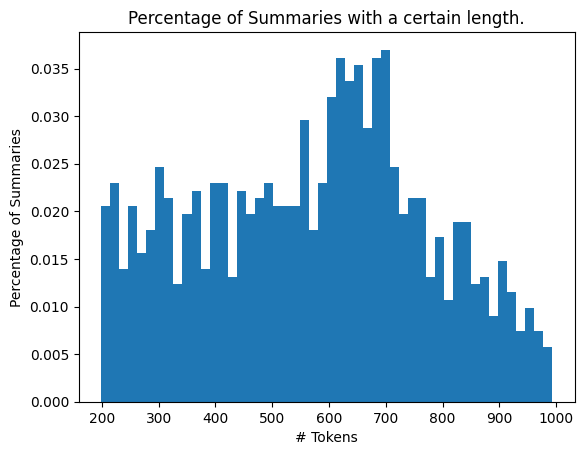

Number of turns 1217


In [11]:
import matplotlib.pyplot as plt

lengths = []
for set_name in ["train", "valid"]:
    for summary in summaries[set_name].values():
        lengths.append(len(summary.split(" ")))

# Create the bar plot
y, bins, fig = plt.hist(lengths, 50, weights=[1/len(lengths)]*len(lengths))
plt.xlabel("# Tokens")
plt.ylabel("Percentage of Summaries")
plt.title("Percentage of Summaries with a certain length.")
plt.show()
print(f"Number of turns {len(lengths)}")

## Retriever Stats

### Full test-set

In [13]:
import json
from tqdm import tqdm

for split in ["train", "valid", "test"]:
    with open(f"../data/NarrativeQA/{split}.json", "r") as f:
        data = json.load(f)
    top_k_accuracy = {1: 0, 3: 0, 5: 0}
    for sample in tqdm(data["questions"], desc=f"Analysing {split} samples"):
        document_id = sample["document_id"]
        retrieved_summary = [summary["summary_id"] for summary in sample["retrieved_summaries"]]
        for i in [1, 3, 5]:
            if document_id in retrieved_summary[:i]:
                top_k_accuracy[i] += 1
    for i in [1, 3, 5]:
        top_k_accuracy[i] /= len(data["questions"])
        print(f"\tRecall@{i} for {split}: {top_k_accuracy[i]*100}")
    
    

Analysing train samples: 100%|██████████| 32747/32747 [00:00<00:00, 873716.62it/s]


	Recall@1 for train: 37.63398173878523
	Recall@3 for train: 50.03511772070725
	Recall@5 for train: 55.153143799432016


Analysing valid samples: 100%|██████████| 3461/3461 [00:00<00:00, 251072.09it/s]


	Recall@1 for valid: 57.757873446980646
	Recall@3 for valid: 71.62669748627565
	Recall@5 for valid: 77.46316093614563


Analysing test samples: 100%|██████████| 10557/10557 [00:00<00:00, 880863.92it/s]

	Recall@1 for test: 46.91673770957658
	Recall@3 for test: 58.690915979918536
	Recall@5 for test: 63.7018092261059


### Question w/ NE

In [31]:
import json

import spacy
from tqdm import tqdm

nlp = spacy.load("en_core_web_trf")

for split in ["train", "valid", "test"]:
    document_set = set()
    valid_questions = 0
    with open(f"../data/NarrativeQA/{split}.json", "r") as f:
        data = json.load(f)
    
    top_k_accuracy = {1: 0, 3: 0, 5: 0}
    for sample in tqdm(data["questions"], desc=f"Analysing {split} samples"):
        doc = nlp(sample["question"])

        if len(doc.ents) == 0:
            continue

        valid_questions += 1

        document_id = sample["document_id"]
        document_set.add(document_id)
        retrieved_summary = [summary["summary_id"] for summary in sample["retrieved_summaries"]]
        for i in [1, 3, 5]:
            if document_id in retrieved_summary[:i]:
                top_k_accuracy[i] += 1
    print(f"Number of documents in {split}: {len(document_set)}")
    for i in [1, 3, 5]:
        top_k_accuracy[i] /= valid_questions
        print(f"\tRecall@{i} for {split}: {top_k_accuracy[i]*100}")
    
    

Analysing train samples: 100%|██████████| 32747/32747 [10:52<00:00, 50.15it/s]


Number of documents in train: 1101
	Recall@1 for train: 40.972349052124045
	Recall@3 for train: 53.97596522628484
	Recall@5 for train: 59.173758994776634


Analysing valid samples: 100%|██████████| 3461/3461 [01:08<00:00, 50.69it/s]


Number of documents in valid: 115
	Recall@1 for valid: 61.87268440552375
	Recall@3 for valid: 75.07578309195016
	Recall@5 for valid: 80.63320983496126


Analysing test samples: 100%|██████████| 10557/10557 [03:29<00:00, 50.31it/s]

Number of documents in test: 354
	Recall@1 for test: 50.648471861960076
	Recall@3 for test: 62.52396526446374
	Recall@5 for test: 67.33957370023683


### Question w/o NE

In [30]:
import json

import spacy
from tqdm import tqdm

nlp = spacy.load("en_core_web_trf")

for split in ["train", "valid", "test"]:
    document_set = set()
    valid_questions = 0
    with open(f"../data/NarrativeQA/{split}.json", "r") as f:
        data = json.load(f)
    
    top_k_accuracy = {1: 0, 3: 0, 5: 0}
    for sample in tqdm(data["questions"], desc=f"Analysing {split} samples"):
        doc = nlp(sample["question"])

        if len(doc.ents) > 0:
            continue

        valid_questions += 1

        document_id = sample["document_id"]
        document_set.add(document_id)
        retrieved_summary = [summary["summary_id"] for summary in sample["retrieved_summaries"]]
        for i in [1, 3, 5]:
            if document_id in retrieved_summary[:i]:
                top_k_accuracy[i] += 1
    print(f"Number of documents in {split}: {len(document_set)}")
    for i in [1, 3, 5]:
        top_k_accuracy[i] /= valid_questions
        print(f"\tRecall@{i} for {split}: {top_k_accuracy[i]*100}")
    
    

Analysing test samples: 100%|██████████| 10557/10557 [03:32<00:00, 49.72it/s]

Number of documents in test: 324
	Recall@1 for test: 27.337278106508876
	Recall@3 for test: 38.57988165680473
	Recall@5 for test: 44.61538461538462


## Generation stats

In [1]:
from utils import collect_task_replies

task_replies = collect_task_replies("../output/NarrativeQA/")

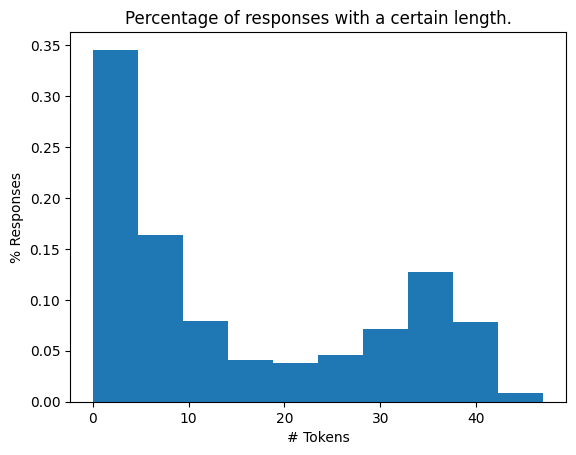

# candidates 168912


In [2]:
import matplotlib.pyplot as plt

lengths = []
for sample_id, sample in task_replies.items():
    for c_name, candidate in sample.items():
        if c_name == "gt":
            continue
        lengths.append(len(candidate.split()))

y, bins, fig = plt.hist(lengths, 10, weights=[1/len(lengths)]*len(lengths))
plt.xlabel("# Tokens")
plt.ylabel("% Responses")
plt.title("Percentage of responses with a certain length.")
plt.show()
print(f"# candidates {len(lengths)}")


In [5]:
len_threshold = 50
lengths_lower_than_threshold = [l for l in lengths if l <= len_threshold]
print(f"Percentage of responses with length lower than {len_threshold}: {round(len(lengths_lower_than_threshold)/len(lengths)*100, 2)}%")

Percentage of responses with length lower than 50: 100.0%


## Sample dialogues for human evaluation

#### Random Sampling

In [1]:
import json

from tqdm import tqdm

from utils import collect_task_replies, fix_replies_if_necessary

task_replies = collect_task_replies("../output/NarrativeQA")

with open("../data/NarrativeQA/test.json", "r") as f:
    data = json.load(f)["questions"]

document_set = set() # type: ignore
valid_samples = {}
for sample in tqdm(data, desc="Processing samples"):
    document_id = sample["document_id"]
    question_id = sample["question_id"]
    sample_id = f"{document_id}_{question_id}"
    document_set.add(document_id)

    replies = {model: reply.lower() for model, reply in task_replies[sample_id].items()}

    try:
        candidates = fix_replies_if_necessary(replies, max_tokens=12, max_sentences=2, max_candidate_length=40)
    except:
        continue

    identical_candidates = {}
    for c_name, c in candidates.items():
        remaining_candidates = [value for key, value in candidates.items() if key != c_name]
        if c in remaining_candidates:
            if c not in identical_candidates:
                identical_candidates[c] = []
            identical_candidates[c].append(c_name)

    new_candidates = {}
    for c_name, c in candidates.items():
        if c not in identical_candidates:
            new_candidates[c_name] = c
    
    for c in identical_candidates:
        if "gt" in identical_candidates[c]:
            c_name = "gt"
        else:
            c_name = identical_candidates[c][0]
        new_candidates[c_name] = c

    if document_id not in valid_samples:
        valid_samples[document_id] = {}

    valid_samples[document_id][sample_id] = {
        "sample_id": sample_id,
        "document_id": document_id,
        "question_id": question_id,
        "history": sample["question"].lower(),
        "candidates": new_candidates,
        "idenitical_candidates": identical_candidates,
    }

print("Number of samples:", len(document_set))
print("Number of valid samples:", len(valid_samples))

Processing samples: 100%|██████████| 10557/10557 [00:04<00:00, 2200.20it/s]

Number of samples: 355
Number of valid samples: 355


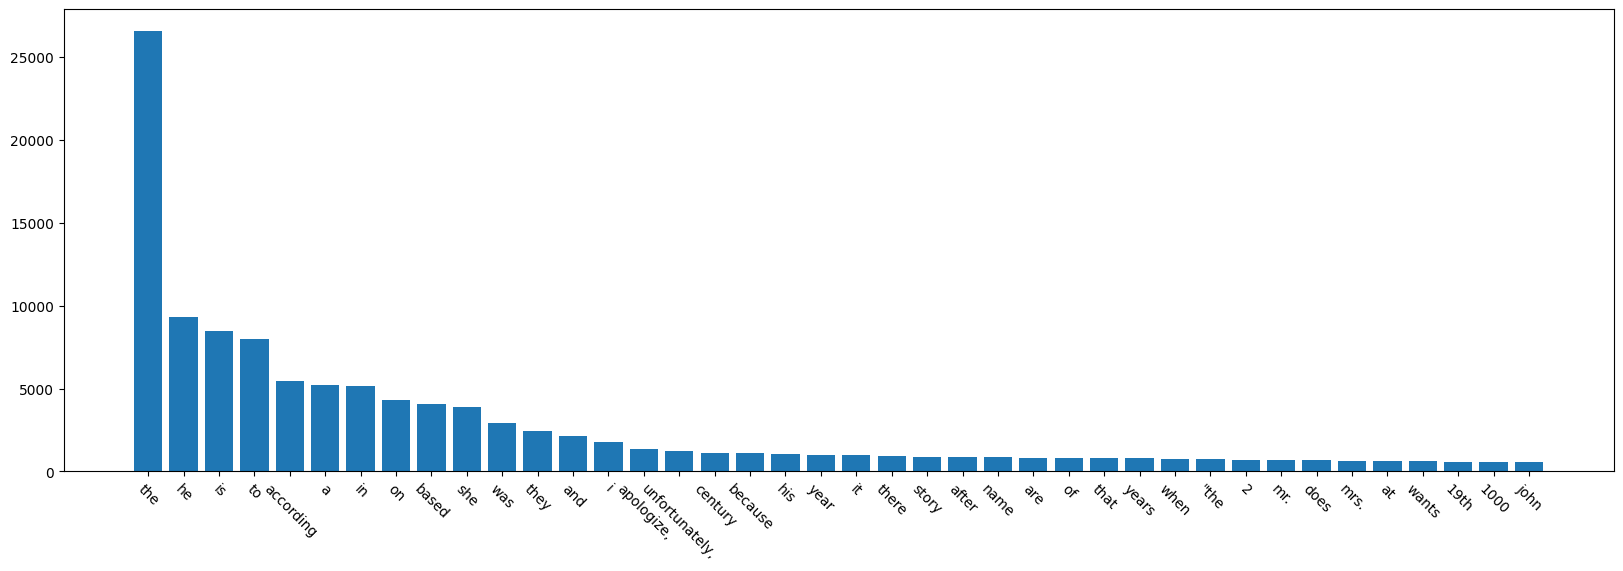

In [2]:
from collections import Counter
import matplotlib.pyplot as plt

tokens = Counter()
for samples_per_document in valid_samples.values():
    for sample in samples_per_document.values():
        for candidate in sample["candidates"].values():
            tokens.update([w.lower() for w in candidate.split()[:2]])


most_common = tokens.most_common(200)

plt.figure(figsize=(20, 6))
plt.bar([k[0] for k in most_common[:40]], [k[1] for k in most_common[:40]])
plt.xticks(rotation=-45)
plt.show()



In [3]:
import os
import random
from statistics import mean

from utils import get_candidates_per_batch

random.seed(7)

n_dial_to_sample = 20

blacklist = [
    "5ad9844f125d7051ba23edbb8b48a74f4f6102c8",
    "c5fbceeedd74bdb32ed744381e7edd65cfd17a8a"
]

doucument_keys = list(valid_samples.keys())
random.shuffle(doucument_keys)
for document_id in blacklist:
    doucument_keys.remove(document_id)

samples_to_eval = {}
for document_id in doucument_keys[:n_dial_to_sample]:
    sample_id, sample = random.sample(list(valid_samples[document_id].items()), 1).pop()
    samples_to_eval[sample_id] = sample

print("Number of sampled dialogues:", len(samples_to_eval))

with open("../data/NarrativeQA/samples_to_eval.json", "w") as f:
    json.dump(samples_to_eval, f, indent=4)

with open("../data/NarrativeQA/summaries.json", "r") as f:
    summaries = json.load(f)

for sample in task_replies.values():
    model_candidates = list(sample.keys())
    break

print("Number of candidates:", len(model_candidates))

candidates_per_batch = get_candidates_per_batch(model_candidates, 4)

with open("../data/NarrativeQA/test_kb.json", "r") as f:
    long_summaries = json.load(f)

for batch_id, candidates in enumerate(candidates_per_batch):
    samples_per_batch_to_eval = {}
    actual_candidates = []
    summary_lenghts = []
    for sample_id, sample in samples_to_eval.items():
        summary_lenghts.append(len(long_summaries[sample["document_id"]]["summary"].split()))
        samples_per_batch_to_eval[sample_id] = {
            "sample_id": sample_id,
            "document_id": sample["document_id"],
            "question_id": sample["question_id"],
            "history": [f"<b>Context:</b> {summaries[sample['document_id']]}<br><br><b>Question:</b> {sample['history']}"],
            "candidates": {model: sample["candidates"][model] for model in candidates if model in sample["candidates"]},
        }
        # add the ground truth
        samples_per_batch_to_eval[sample_id]["candidates"]["gt"] = sample["candidates"]["gt"]
        actual_candidates.append(len(samples_per_batch_to_eval[sample_id]["candidates"]))
    print(f"Number of samples in batch {batch_id}:", len(samples_per_batch_to_eval))
    print(f"\tAvg Number of candidates in batch {batch_id}:", mean(actual_candidates))
    print(f"\tMin number of candidates in batch {batch_id}:", min(actual_candidates))
    print(f"\tMax number of candidates in batch {batch_id}:", max(actual_candidates))

    out_folder = f"../data/NarrativeQA/human_eval/batch_{batch_id}"
    os.makedirs(out_folder, exist_ok=True)
    with open(f"{out_folder}/samples_to_eval.json", "w") as f:
        json.dump(samples_per_batch_to_eval, f, indent=4)

print("Average summary length:", mean(summary_lenghts))
print("Min summary length:", min(summary_lenghts))
print("Max summary length:", max(summary_lenghts))

Number of sampled dialogues: 20
Number of candidates: 17
Number of samples in batch 0: 20
	Avg Number of candidates in batch 0: 4.25
	Min number of candidates in batch 0: 3
	Max number of candidates in batch 0: 5
Number of samples in batch 1: 20
	Avg Number of candidates in batch 1: 4.4
	Min number of candidates in batch 1: 3
	Max number of candidates in batch 1: 5
Number of samples in batch 2: 20
	Avg Number of candidates in batch 2: 4.3
	Min number of candidates in batch 2: 3
	Max number of candidates in batch 2: 5
Number of samples in batch 3: 20
	Avg Number of candidates in batch 3: 3.75
	Min number of candidates in batch 3: 2
	Max number of candidates in batch 3: 5
Average summary length: 565.55
Min summary length: 201
Max summary length: 921


## Sample dialogues for generation

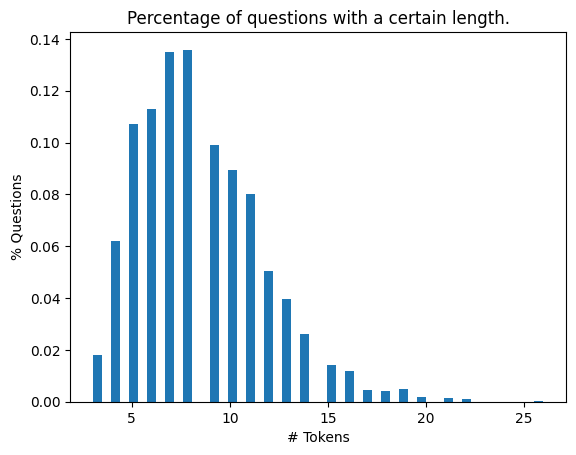

Number of turns 3461


In [13]:
import matplotlib.pyplot as plt

# Calculate the length per turn
lengths = []
for q in questions["valid"]["samples"].values():
    lengths.append(len(q["questions"].split()))

# Create the bar plot
y, bins, fig = plt.hist(lengths, 50, weights=[1/len(lengths)]*len(lengths))
plt.xlabel("# Tokens")
plt.ylabel("% Questions")
plt.title("Percentage of questions with a certain length.")
plt.show()
print(f"Number of turns {len(lengths)}")


In [15]:
from tqdm import tqdm
import random

def prepare_split(questions, bins, split_size):

    random.seed(42)
    dataset = {}
    for q_idx, q in tqdm(questions.items(), desc=f"Preparing Stratified split"):
        for i, bin in enumerate(bins[1:]):
            if len(q["questions"].split()) <= bin:
                if i not in dataset:
                    dataset[i] = []
                dataset[i].append({
                    "document_id": q["document_id"],
                    "question_id": q_idx,
                    "question": q["questions"],
                })
                break
    splits = []
    for i, split in dataset.items():
        try:
            splits += random.sample(split, int(len(split) * split_size))
        except ValueError:
            continue

    return splits

In [16]:
splits = prepare_split(questions["valid"]["samples"], bins, 0.1)
len(splits)

Preparing Stratified split:   0%|          | 0/3461 [00:00<?, ?it/s]

Preparing Stratified split: 100%|██████████| 3461/3461 [00:00<00:00, 78570.27it/s]


337

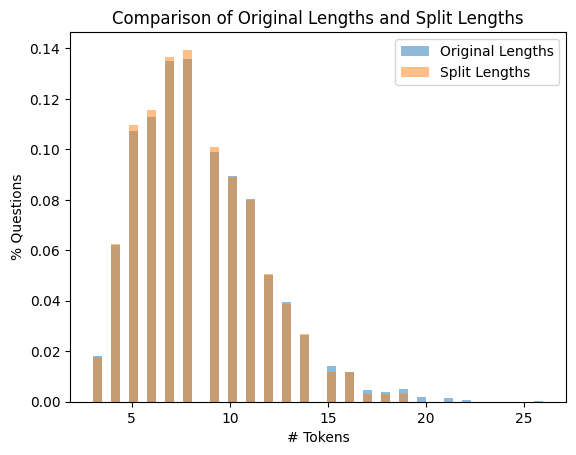

In [19]:
plt.hist(lengths, bins, weights=[1/len(lengths)]*len(lengths), alpha=0.5, label='Original Lengths')
plt.hist([len(sample["question"].split()) for sample in splits], bins, weights=[1/len(splits)]*len(splits), alpha=0.5, label='Split Lengths')
plt.xlabel("# Tokens")
plt.ylabel("% Questions")
plt.title("Comparison of Original Lengths and Split Lengths")
plt.legend()
plt.show()


In [41]:
import json
from copy import deepcopy

with open("../data/NarrativeQA/valid.json", "r") as f:
    valid = json.load(f)

dataset = {}
for sample in splits:
    dataset[f'{sample["document_id"]}_{sample["question_id"]}'] = sample

with open("valid_optimization.json", "w") as f:
    json.dump(splits, f, indent=4)

valid_optimization = deepcopy(valid)
for sample in valid["questions"]:
    key = f'{sample["document_id"]}_{sample["question_id"]}'
    if key not in dataset:
        valid_optimization["questions"].remove(sample)

assert len(valid_optimization["questions"]) == len(splits)

with open("valid_optimization.json", "w") as f:
    json.dump(valid_optimization, f, indent=4)

In [1]:
from transformers import AutoTokenizer

llama = "meta-llama/Llama-2-7b-chat-hf"
mistral = "mistralai/Mistral-7B-Instruct-v0.1"

/home/simone/miniconda3/envs/inlg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
from tqdm import tqdm
import statistics
tokenizer = AutoTokenizer.from_pretrained(llama)

lengths = []
for sample in tqdm(splits):
    sample["input_ids"] = tokenizer(sample["question"])
    lengths.append(len(sample["input_ids"]["input_ids"]))

max_length = max(lengths)
mean_length = statistics.mean(lengths)

print("Maximum Length:", max_length)
print("Mean Length:", mean_length)


100%|██████████| 337/337 [00:00<00:00, 10672.93it/s]

Maximum Length: 29
Mean Length: 12.952522255192878


In [3]:
from tqdm import tqdm
import statistics
import json

tokenizer = AutoTokenizer.from_pretrained(llama)

with open("../data/NarrativeQA/valid.json", "r") as f:
    valid = json.load(f)

lengths = []
for sample in tqdm(valid["questions"]):
    sample["input_ids"] = tokenizer(sample["question"])
    lengths.append(len(sample["input_ids"]["input_ids"]))

max_length = max(lengths)
mean_length = statistics.mean(lengths)

print("Maximum Length:", max_length)
print("Mean Length:", mean_length)


100%|██████████| 3461/3461 [00:00<00:00, 23653.58it/s]

Maximum Length: 35
Mean Length: 13.114706732158336


## Error Analysis

In [2]:
import json
from pathlib import Path

import evaluate
import pandas as pd
from parlai.core.metrics import TeacherMetrics
from tqdm import tqdm

rouge = evaluate.load('rouge')

with open("../data/NarrativeQA/test.json", "r") as f:
    data = json.load(f)

### BLEU

In [9]:
from utils import collect_task_replies

task_replies = collect_task_replies("../output/NarrativeQA")

techniques = {}
for sample in tqdm(data["questions"], desc="Computing F1"):
    sample_id = f"{sample['document_id']}_{sample['question_id']}"
    reference = sample["answers"]

    for key, value in task_replies[sample_id].items():
        if key == "gt":
            continue
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": value}, reference)


for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['bleu-4']}")

Computing F1: 100%|██████████| 10557/10557 [00:25<00:00, 420.54it/s]

llama_prompt_gold: 0.02896
llama_ft_retrieved_top-1: 0.05635
llama_ft_gold: 0.1152
llama_ft_retrieved_top-3: 0.06626
llama_prompt_retrieved_top-3: 0.01408
llama_ft_none: 0.006003
llama_prompt_none: 0.001036
llama_prompt_retrieved_top-1: 0.01506
mistral_prompt_gold: 0.02488
mistral_ft_none: 0.002705
mistral_ft_gold: 0.1046
mistral_ft_retrieved_top-3: 0.06535
mistral_prompt_retrieved_top-3: 0.008567
mistral_prompt_none: 0.001077
mistral_ft_retrieved_top-1: 0.05533
mistral_prompt_retrieved_top-1: 0.0123


### BLEU - Plots

In [10]:
from utils import collect_task_replies

task_replies = collect_task_replies("../output/NarrativeQA")

task_replies = {sample_id: {c_name: candidate.lower() for c_name, candidate in sample.items()} for sample_id, sample in task_replies.items()}

replacements = {
    "_": " ",
    ".json": "",
    "mistral": "Mistral",
    "llama": "Llama2",
    "gt": "Ground Truth",
    "none": "",
    "retrieved": "",
    "top-1": "Top 1",
    "top-3": "Top 3",
    "gold": "Gold",
    "prompt": "Prompt",
    "ft": "Fine-Tuned",
    "  ": " ",
}

#### Average

In [11]:
from utils import plot_cross_bleu

candidates = [
    "gt",
    "llama_ft_none.json",
    "llama_ft_retrieved_top-1.json",
    "llama_ft_retrieved_top-3.json",
    "llama_ft_gold.json",
    "llama_prompt_none.json",
    "llama_prompt_retrieved_top-1.json",
    "llama_prompt_retrieved_top-3.json",
    "llama_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'])

Computing cross BLEU: 100%|██████████| 10557/10557 [01:56<00:00, 90.94it/s] 


In [12]:
candidates = [
    "gt",
    "mistral_ft_none.json",
    "mistral_ft_retrieved_top-1.json",
    "mistral_ft_retrieved_top-3.json",
    "mistral_ft_gold.json",
    "mistral_prompt_none.json",
    "mistral_prompt_retrieved_top-1.json",
    "mistral_prompt_retrieved_top-3.json",
    "mistral_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'])

Computing cross BLEU:   0%|          | 0/10557 [00:00<?, ?it/s]

Computing cross BLEU: 100%|██████████| 10557/10557 [01:56<00:00, 90.72it/s]


#### Max

In [17]:
candidates = [
    "gt",
    "llama_ft_none.json",
    "llama_ft_retrieved_top-1.json",
    "llama_ft_retrieved_top-3.json",
    "llama_ft_gold.json",
    "llama_prompt_none.json",
    "llama_prompt_retrieved_top-1.json",
    "llama_prompt_retrieved_top-3.json",
    "llama_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'], operation="max")

Computing cross BLEU: 100%|██████████| 10557/10557 [01:56<00:00, 90.62it/s] 


In [13]:
candidates = [
    "gt",
    "mistral_ft_none.json",
    "mistral_ft_retrieved_top-1.json",
    "mistral_ft_retrieved_top-3.json",
    "mistral_ft_gold.json",
    "mistral_prompt_none.json",
    "mistral_prompt_retrieved_top-1.json",
    "mistral_prompt_retrieved_top-3.json",
    "mistral_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'], operation="max")

Computing cross BLEU: 100%|██████████| 10557/10557 [01:56<00:00, 90.32it/s] 


#### Samples above a threshold

In [14]:
from utils import get_samples_above_threshold


candidates = [
    "gt",
    "llama_ft_none.json",
    "llama_ft_retrieved_top-1.json",
    "llama_ft_retrieved_top-3.json",
    "llama_ft_gold.json",
    "llama_prompt_none.json",
    "llama_prompt_retrieved_top-1.json",
    "llama_prompt_retrieved_top-3.json",
    "llama_prompt_gold.json",
]

llama_samples_above_threshold = get_samples_above_threshold(task_replies, candidates, threshold=1)

print(f"Number of samples above threshold: {round(len(llama_samples_above_threshold)/len(task_replies)*100, 2)}%")

  0%|          | 0/10557 [00:00<?, ?it/s]

100%|██████████| 10557/10557 [00:49<00:00, 212.51it/s]

Number of samples above threshold: 34.14%


In [15]:
from utils import get_samples_above_threshold


candidates = [
    "gt",
    "mistral_ft_none.json",
    "mistral_ft_retrieved_top-1.json",
    "mistral_ft_retrieved_top-3.json",
    "mistral_ft_gold.json",
    "mistral_prompt_none.json",
    "mistral_prompt_retrieved_top-1.json",
    "mistral_prompt_retrieved_top-3.json",
    "mistral_prompt_gold.json",
]

mistral_samples_above_threshold = get_samples_above_threshold(task_replies, candidates, threshold=1)

print(f"Number of samples above threshold: {round(len(mistral_samples_above_threshold)/len(task_replies)*100, 2)}%")

  0%|          | 0/10557 [00:00<?, ?it/s]

100%|██████████| 10557/10557 [00:49<00:00, 213.03it/s]

Number of samples above threshold: 29.14%


In [16]:
total_samples_above_threshold = llama_samples_above_threshold.union(mistral_samples_above_threshold)
print(f"Total number of samples above threshold: {round(len(total_samples_above_threshold)/len(task_replies)*100, 2)}%")

Total number of samples above threshold: 45.34%


### ROUGE-L

#### Full test set

In [1]:
import re

from utils import collect_task_replies

task_replies = collect_task_replies("../output/NarrativeQA")

rougeL = {}
references = []
predictions = {}
for sample in tqdm(data["questions"]):
    sample_id = f'{sample["document_id"]}_{sample["question_id"]}'
    references.append([re.sub(r"[^0-9a-zA-Z\s]+", "", answer.lower()) for answer in sample["answers"]])
    for key, value in task_replies[sample_id].items():
        if key == "gt":
            continue
        if key not in predictions:
            predictions[key] = []
        predictions[key].append(re.sub(r"[^0-9a-zA-Z\s]+", "",value.lower()))

for p in tqdm(predictions, desc="Calculating ROUGE-L"):
    rougeL[p] = rouge.compute(predictions=predictions[p], references=references)

NameError: name 'tqdm' is not defined

In [12]:
scores = {}

for p in rougeL:
    scores[p] = {
        "rougeL": rougeL[p]["rougeL"]
    }

df = pd.DataFrame(scores).T * 100
df.round(2)

,rougeL
llama_prompt_gold,22.98
llama_ft_retrieved_top-1,40.13
llama_ft_gold,73.04
llama_ft_retrieved_top-3,45.99
llama_prompt_retrieved_top-3,14.69
llama_ft_none,17.07
llama_prompt_none,5.42
llama_prompt_retrieved_top-1,14.57
mistral_prompt_gold,21.51
mistral_ft_none,12.56


In [4]:
rougeL = {}
references = []
predictions = {}
for sample in tqdm(data["questions"]):
    sample_id = f'{sample["document_id"]}_{sample["question_id"]}'
    references.append(sample["answers"])
    for key, value in task_replies[sample_id].items():
        if key == "gt":
            continue
        if key not in predictions:
            predictions[key] = []
        predictions[key].append(value)

for p in tqdm(predictions, desc="Calculating ROUGE-L"):
    rougeL[p] = rouge.compute(predictions=predictions[p], references=references)

Calculating ROUGE-L:   0%|          | 0/17 [00:00<?, ?it/s]

Calculating ROUGE-L: 100%|██████████| 17/17 [01:21<00:00,  4.82s/it]


In [5]:
scores = {}

for p in rougeL:
    scores[p] = {
        "rougeL": rougeL[p]["rougeL"]
    }

df = pd.DataFrame(scores).T * 100
df.round(2)

,rougeL
llama_prompt_gold.json,23.21
llama_ft_retrieved_top-1.json,40.35
llama_ft_gold.json,73.37
llama_ft_retrieved_top-3.json,46.22
llama_prompt_retrieved_top-3.json,14.86
llama_ft_none.json,17.25
llama_prompt_none.json,5.59
llama_prompt_retrieved_top-1.json,14.76
mistral_prompt_gold.json,21.75
mistral_ft_none.json,12.74


#### Samples with correctly retrieved documents

##### Top-1

In [ ]:
rougeL = {}
references = []
predictions = {}
for sample in tqdm(data["questions"]):
    sample_id = f'{sample["document_id"]}_{sample["question_id"]}'
    retrieved_summaries = [summary["summary_id"] for summary in sample["retrieved_summaries"]]
    if sample["document_id"] not in retrieved_summaries[:1]:
        continue

    references.append(sample["answers"])

    for key, value in task_replies[sample_id].items():
        if "retrieved_top-1" in key or "gold" in key:
            if key not in predictions:
                predictions[key] = []
            predictions[key].append(value)

for p in tqdm(predictions, desc="Calculating ROUGE-L"):
    rougeL[p] = rouge.compute(predictions=predictions[p], references=references)

Calculating ROUGE-L: 100%|██████████| 8/8 [00:17<00:00,  2.21s/it]


In [ ]:
scores = {}

for p in rougeL:
    scores[p] = {
        "rougeL": rougeL[p]["rougeL"]
    }

df = pd.DataFrame(scores).T * 100
df.round(2)

,rougeL
llama_prompt_gold.json,22.93
llama_ft_retrieved_top-1.json,69.25
llama_ft_gold.json,72.08
llama_prompt_retrieved_top-1.json,23.06
mistral_prompt_gold.json,22.65
mistral_ft_gold.json,69.42
mistral_ft_retrieved_top-1.json,70.74
mistral_prompt_retrieved_top-1.json,22.29


##### Top-3

In [16]:
rougeL = {}
references = []
predictions = {}
for sample in tqdm(data["questions"]):
    sample_id = f'{sample["document_id"]}_{sample["question_id"]}'
    retrieved_summaries = [summary["summary_id"] for summary in sample["retrieved_summaries"]]
    if sample["document_id"] not in retrieved_summaries[:3]:
        continue

    references.append(sample["answers"])

    for key, value in task_replies[sample_id].items():
        if "retrieved_top-3" in key or "gold" in key:
            if key not in predictions:
                predictions[key] = []
            predictions[key].append(value)

for p in tqdm(predictions, desc="Calculating ROUGE-L"):
    rougeL[p] = rouge.compute(predictions=predictions[p], references=references)

  0%|          | 0/10557 [00:00<?, ?it/s]

Calculating ROUGE-L: 100%|██████████| 8/8 [00:20<00:00,  2.59s/it]


In [17]:
scores = {}

for p in rougeL:
    scores[p] = {
        "rougeL": rougeL[p]["rougeL"]
    }

df = pd.DataFrame(scores).T * 100
df.round(2)

,rougeL
llama_prompt_gold.json,22.80
llama_ft_gold.json,72.29
llama_ft_retrieved_top-3.json,68.70
llama_prompt_retrieved_top-3.json,20.04
mistral_prompt_gold.json,22.30
mistral_ft_gold.json,69.48
mistral_ft_retrieved_top-3.json,68.20
mistral_prompt_retrieved_top-3.json,13.52


### KF1

In [3]:
import csv

from tqdm import tqdm

summaries = {
    "train": {},
    "valid": {},
    "test": {}
}
with open('../original_data/NarrativeQA/summaries.csv', 'r') as f:
    csvreader = csv.DictReader(f)
    for row in tqdm(csvreader, desc="analysing summaries"):
        summaries[row["set"]][row["document_id"]] = row["summary"]

analysing summaries: 1572it [00:00, 14716.86it/s]


#### Full test set

In [4]:
techniques = {}
for sample in tqdm(data["questions"], desc="Computing KF1"):
    sample_id = f'{sample["document_id"]}_{sample["question_id"]}'
    summary = summaries["test"][sample["document_id"]]
    for key, value in task_replies[sample_id].items():
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": re.sub(r"[^0-9a-zA-Z\s]+", "",value.lower())}, [re.sub(r"[^0-9a-zA-Z\s]+", "", summary.lower())])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1:   0%|          | 0/10557 [00:00<?, ?it/s]

Computing KF1: 100%|██████████| 10557/10557 [02:28<00:00, 71.16it/s] 

gt: 0.01502
llama_prompt_gold: 0.06597
llama_ft_retrieved_top-1: 0.01031
llama_ft_gold: 0.01426
llama_ft_retrieved_top-3: 0.01135
llama_prompt_retrieved_top-3: 0.05549
llama_ft_none: 0.007263
llama_prompt_none: 0.05115
llama_prompt_retrieved_top-1: 0.05727
mistral_prompt_gold: 0.0698
mistral_ft_none: 0.00651
mistral_ft_gold: 0.01451
mistral_ft_retrieved_top-3: 0.01171
mistral_prompt_retrieved_top-3: 0.06005
mistral_prompt_none: 0.04712
mistral_ft_retrieved_top-1: 0.01076
mistral_prompt_retrieved_top-1: 0.05596


#### Samples with correctly retrieved documents

##### Top-1

In [23]:
techniques = {}
for sample in tqdm(data["questions"], desc="Computing KF1"):
    sample_id = f'{sample["document_id"]}_{sample["question_id"]}'
    retrieved_summaries = [summary["summary_id"] for summary in sample["retrieved_summaries"]]
    if sample["document_id"] not in retrieved_summaries[:1]:
        continue

    summary = summaries["test"][sample["document_id"]]
    for key, value in task_replies[sample_id].items():
        if "retrieved_top-1" in key or "gold" in key or "gt" in key:
            if key not in techniques:
                techniques[key] = TeacherMetrics()
            techniques[key].evaluate_response({"text": value}, [summary])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1: 100%|██████████| 10557/10557 [00:37<00:00, 282.31it/s]

gt: 0.01679
llama_prompt_gold.json: 0.07306
llama_ft_retrieved_top-1.json: 0.01516
llama_ft_gold.json: 0.01583
llama_prompt_retrieved_top-1.json: 0.07306
mistral_prompt_gold.json: 0.07588
mistral_ft_gold.json: 0.01619
mistral_ft_retrieved_top-1.json: 0.01564
mistral_prompt_retrieved_top-1.json: 0.07544


##### Top-3

In [24]:
techniques = {}
for sample in tqdm(data["questions"], desc="Computing KF1"):
    sample_id = f'{sample["document_id"]}_{sample["question_id"]}'
    retrieved_summaries = [summary["summary_id"] for summary in sample["retrieved_summaries"]]
    if sample["document_id"] not in retrieved_summaries[:3]:
        continue

    summary = summaries["test"][sample["document_id"]]
    for key, value in task_replies[sample_id].items():
        if "retrieved_top-3" in key or "gold" in key or "gt" in key:
            if key not in techniques:
                techniques[key] = TeacherMetrics()
            techniques[key].evaluate_response({"text": value}, [summary])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1:   0%|          | 0/10557 [00:00<?, ?it/s]

Computing KF1: 100%|██████████| 10557/10557 [00:47<00:00, 222.05it/s]

gt: 0.01642
llama_prompt_gold.json: 0.07203
llama_ft_gold.json: 0.01551
llama_ft_retrieved_top-3.json: 0.01519
llama_prompt_retrieved_top-3.json: 0.06748
mistral_prompt_gold.json: 0.07457
mistral_ft_gold.json: 0.01584
mistral_ft_retrieved_top-3.json: 0.01559
mistral_prompt_retrieved_top-3.json: 0.07401
